In [18]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from getdist import plots, MCSamples, loadMCSamples
import sys
sys.path.append('../')
import tqdm
from scipy.special import logsumexp
from sigw_fast.sigwfast import sigwfast_mod as gw
from math import sqrt
try:
    from sigw_fast.libraries import sdintegral_numba as sd
except ImportError:
    from sigw_fast.libraries import sdintegral as sd
# Set matplotlib parameters
font = {'size': 16, 'family': 'serif'}
axislabelfontsize = 'large'
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True)
matplotlib.rc('legend', fontsize=16)
blue = '#006FED'

In [19]:
def plot_functional_posterior(vals,samples,k_arr = [], intervals=[99.7, 95., 68.],weights=None,
                              ylabels=[r'$P_{\zeta}$', r'$\Omega_{\rm GW}$'],
                              aspect_ratio=(6, 4.5),
                              interval_cols=[('#006FED', 0.2), ('#006FED', 0.4), ('#006FED', 0.6)]):
    # given a function y = f(k|x) with x~Posterior samples, plot the posterior of y at k_arr, with symmetric credible intervals

    nfuncs = len(vals)

    if weights is None:
        weights = np.ones(len(samples.shape[0]))

    fig, ax = plt.subplots(1,nfuncs,figsize=(aspect_ratio[0]*nfuncs,aspect_ratio[1]),constrained_layout=True)
    if nfuncs == 1:
        ax = [ax]
    for i,val in enumerate(vals):
        y = val # so y should have shape (nsamples, nk)
        for j,interval in enumerate(intervals):
            y_low, y_high = np.percentile(y,[50-interval/2,50+interval/2],axis=0,weights=weights,
                                          method='inverted_cdf')
            ax[i].fill_between(k_arr[i],y_low,y_high,color=interval_cols[j])
        medians = np.apply_along_axis(weighted_median, 0, val, weights)
        ax[i].plot(k_arr[i], medians, color='#006FED', lw=2.5)
        # ax[i].plot(k_arr[i],np.median(y,axis=0),color=blue,lw=2)
        ax[i].set_ylabel(ylabels[i])
    for x in ax:
        x.set(xscale='log', yscale='log', xlabel=r'$f\,{\rm [Hz]}$')
    return fig, ax

def weighted_median(data, weights):
    """
    Compute the weighted median of data.
    """
    # Sort the data and weights.
    s_data, s_weights = map(np.array, zip(*sorted(zip(data, weights))))
    # Compute the cumulative sum of the weights.
    cdf = np.cumsum(s_weights)
    # Find the median value.
    idx = np.searchsorted(cdf, 0.5)
    return s_data[idx]

def resample_equal(samples, logl, logwt, rstate):
    wt = np.exp(logwt)
    weights = wt / wt.sum()
    cumulative_sum = np.cumsum(weights)
    cumulative_sum /= cumulative_sum[-1]
    nsamples = len(weights)
    positions = (rstate.random() + np.arange(nsamples)) / nsamples
    idx = np.zeros(nsamples, dtype=int)
    i, j = 0, 0
    while i < nsamples:
        if positions[i] < cumulative_sum[j]:
            idx[i] = j
            i += 1
        else:
            j += 1
    perm = rstate.permutation(nsamples)
    resampled_samples = samples[idx][perm]
    resampled_logl = logl[idx][perm]
    return resampled_samples, resampled_logl


In [21]:
# Load data
data = np.load('./spectra_0p66_interp.npz')
frequencies = data['frequencies']
gwb_model = 'bpl'
Omegas = data[f'gw_{gwb_model}'] 
kstar = 1e-3
omks_sigma = Omegas * (0.05 * (np.log(frequencies / kstar))**2 + 0.1)
cov = np.diag(omks_sigma**2)
pk_arr = data['pk_arr']
pk_min, pk_max = min(pk_arr), max(pk_arr)
left_node = np.log10(pk_min)
right_node = np.log10(pk_max)
p_arr = np.logspace(left_node+0.001, right_node-0.001, 100)
pz_amp = data[f'pk_{gwb_model}']
num_nodes = 4
# Load samples
sample_data = np.load(f'./{gwb_model}_0p66_interp_free_{num_nodes}.npz')
samples = sample_data['samples']
logwt = sample_data['logwt']
logl = sample_data['logl']
omegagw = sample_data['omegagw']
weights_total = logsumexp(logwt)
weights = np.exp(logwt - weights_total)
weights = weights / np.sum(weights) 

print(f"Shapes: {samples.shape}, {logwt.shape}, {logl.shape}, {omegagw.shape}")


Shapes: (93700, 7), (93700,), (93700,), (93700, 50)


In [22]:
def compute_pz(k,samples):
    Pz = []
    for sample in tqdm.tqdm(samples,desc='Pz'):
        free_nodes = sample[1:num_nodes-1]
        nodes = np.pad(free_nodes, (1,1), 'constant', constant_values=(left_node, right_node))
        vals = sample[num_nodes-1:]
        res = gw.power_spectrum_k_array(nodes, vals, k)
        Pz.append(res)
    return np.array(Pz) # Pz has shape (nsamples, nk)
pz_amps = compute_pz(p_arr, samples)

Pz: 100%|██████████| 93700/93700 [00:00<00:00, 146639.70it/s]


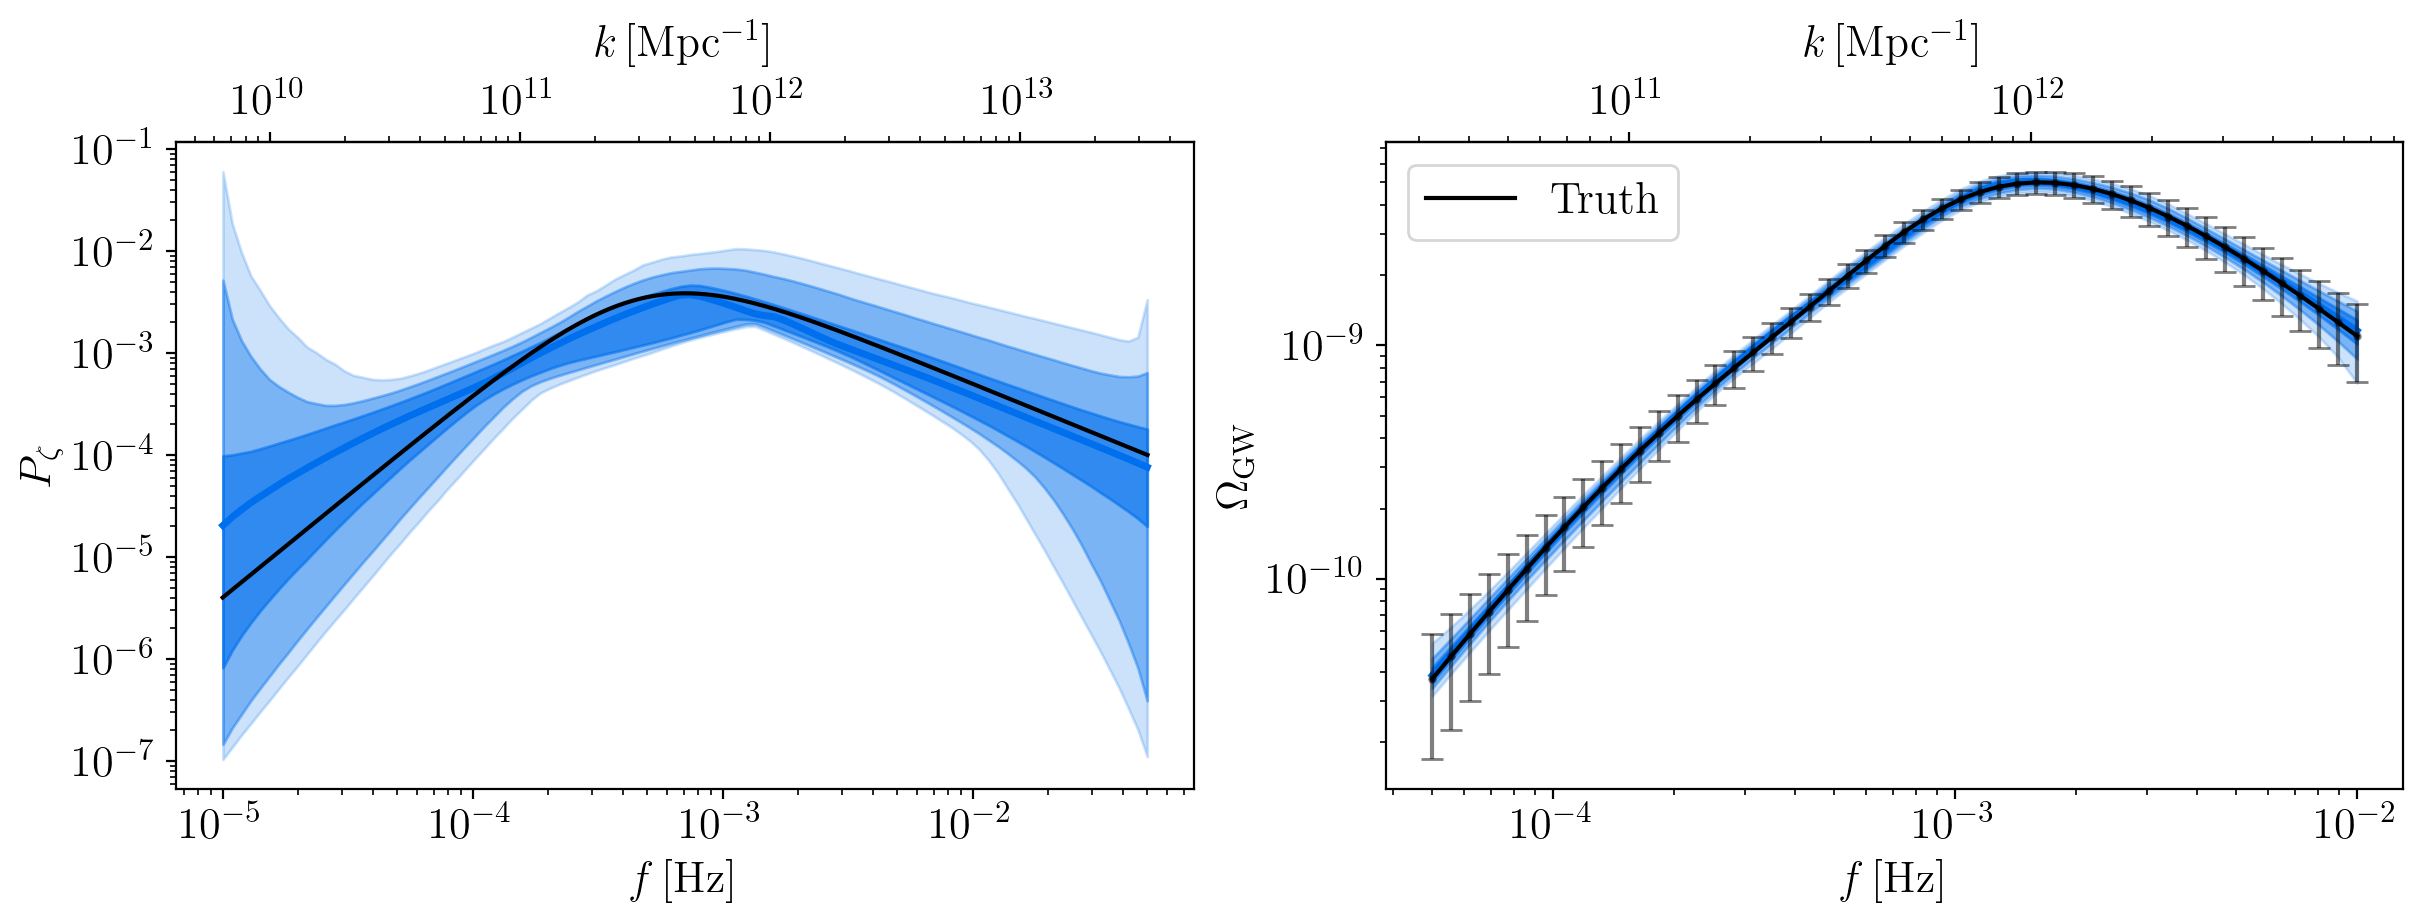

In [23]:
fig,ax = plot_functional_posterior([pz_amps,omegagw], samples, [p_arr,frequencies], weights=weights,)
ax[0].loglog(pk_arr,pz_amp, color='k', lw=1.5)
ax[1].loglog(frequencies, Omegas, color='k', lw=1.5, label='Truth')
ax[1].errorbar(frequencies, Omegas, yerr=np.sqrt(np.diag(cov)), fmt='o', color='k', capsize=4.,alpha=0.5,markersize=2)
ax[1].legend()
k_mpc_f_hz = 2*np.pi * 1.03 * 10**14
for x in ax:
    secax = x.secondary_xaxis('top', functions=(lambda x: x * k_mpc_f_hz, lambda x: x / k_mpc_f_hz))
    secax.set_xlabel(r"$k\,{\rm [Mpc^{-1}]}$",labelpad=10) 
# plt.savefig(f'{gwb_model}_wfld_0p99_{num_nodes}_posterior.pdf',bbox_inches='tight')


{'w': [0.1, 0.99]}
Removed no burn in
Marginalized limits: 0.68; 0.95; 0.99

parameter   mean           sddev          lower1         upper1         limit1 lower2         upper2         limit2 lower3         upper3         limit3 
w           7.4143877E-01  1.2331888E-01  6.8691996E-01  9.9000000E-01  <      5.6462132E-01  9.9000000E-01  <      4.8548484E-01  9.9000000E-01  <       w



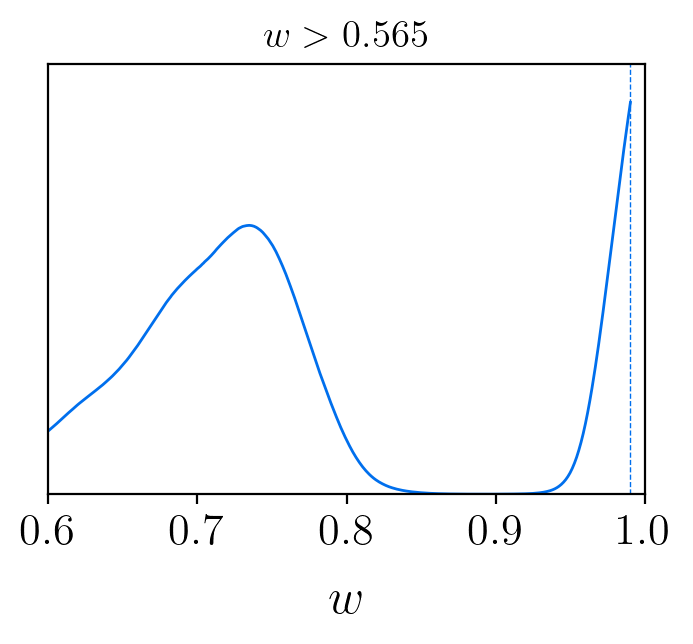

In [24]:
w = 0.99
names = ['w']
labels = ['w']
bounds = [[0.1,0.99]]
ranges = dict(zip(names,bounds))
print(ranges)
# ws = samples[:,0]
# ws = ws[samples[:,0] < 0.9]
# w_weights = weights[samples[:,0] < 0.9]
# print(f"Shapes: {ws.shape}, {weights.shape}")
# # gd_samples = MCSamples(samples=samples[:,0], names=names, labels=labels,ranges=ranges,weights=normalized_weights,loglikes=logl)
# gd_samples = MCSamples(samples=ws, names=names, labels=labels,ranges=ranges,weights=w_weights)
gd_samples = MCSamples(samples=samples[:,0], names=names, labels=labels,ranges=ranges,weights=weights)
g = plots.get_subplot_plotter(subplot_size=3.5)
blue = '#006FED'
g.settings.title_limit_fontsize = 14
g.settings.axes_fontsize=16
g.settings.axes_labelsize=18
g.plot_1d(gd_samples, 'w', marker=w, marker_color=blue, colors=[blue],title_limit=2)
g.export(f'{gwb_model}_wfld_0p99_{num_nodes}_1D_w.pdf')
ax = g.subplots[0,0]
ax.set_xlim(0.6, 1.0)
print(gd_samples.getMargeStats())


Text(0, 0.5, '$\\Omega_{\\rm GW}$')

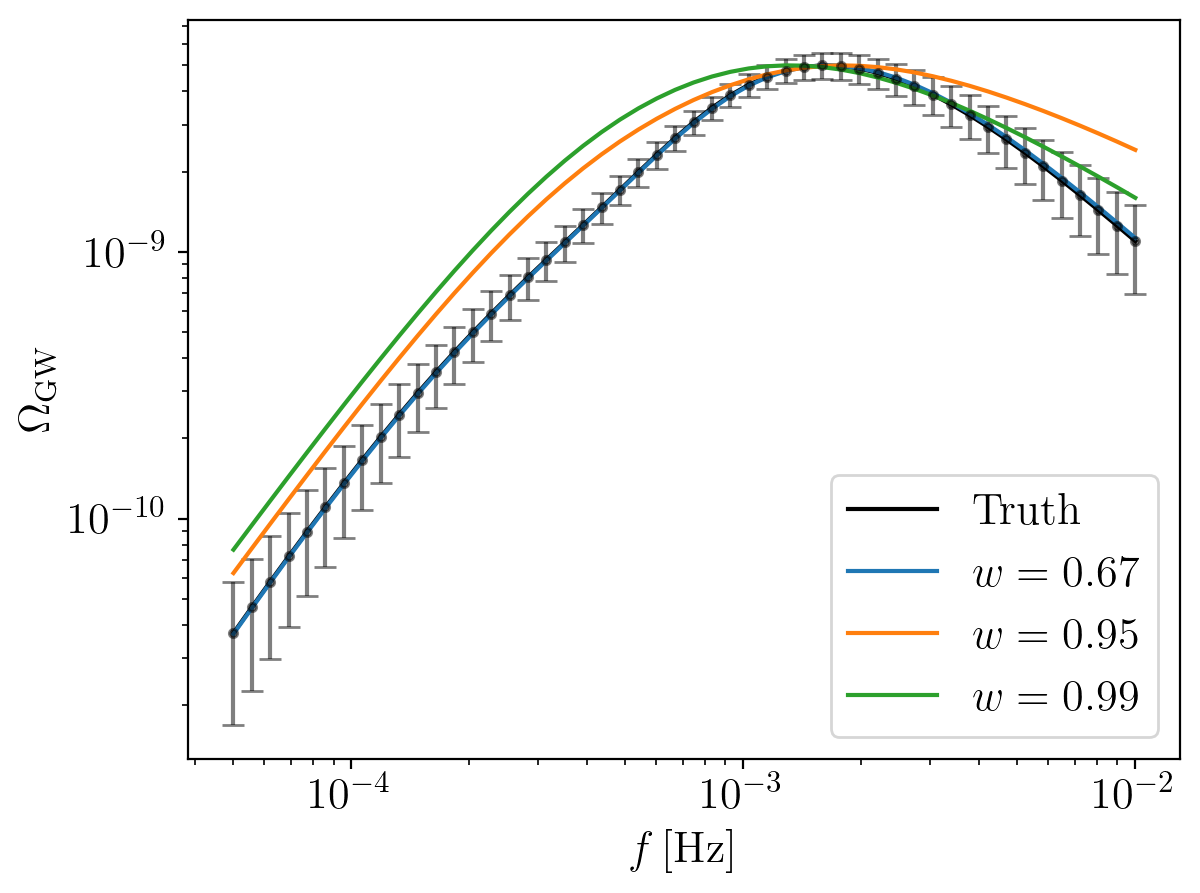

In [13]:
# testing w dependence

OMEGA_R = 4.2 * 10**(-5)
CG = 0.39
rd_norm = CG * OMEGA_R 
nd = 150
SQRTEPS = sqrt(float(np.finfo(np.float64).eps))

def bpl(p, pstar=5e-4, n1=2, n2=-1, sigma=2):
    nir = n1
    pl1 = (p / pstar) ** nir
    nuv = (n2 - n1) / sigma
    pl2 = (1 + (p / pstar) ** sigma) ** nuv
    return 1e-2 * pl1 * pl2


def compute_w(w,log10_f_rh,nodes,vals,frequencies,use_mp=False,nd=150,fref=1.):
    nd,ns1,ns2, darray,d1array,d2array, s1array,s2array = sd.arrays_w(w,frequencies,nd=nd)
    b = sd.beta(w)
    # kernel1, kernel2 = get_kernels(w, d1array, s1array, d2array, s2array)
    kernel1 = sd.kernel1_w(d1array, s1array, b)
    kernel2 = sd.kernel2_w(d2array, s2array, b)
    nk = len(frequencies)
    Integral = np.empty_like(frequencies)
    Integral = gw.compute_w_k_array(nodes = nodes, vals = vals, nk = nk,komega = frequencies, 
                                            kernel1 = kernel1, kernel2 = kernel2, d1array=d1array,
                                            s1array=s1array, d2array=d2array, s2array=s2array,
                                            darray=darray, nd = nd, ns1 = ns1, ns2 = ns2)
    f_rh = 10**log10_f_rh
    two_b = 2*b
    norm = rd_norm * (frequencies)**(-2*b) *  (f_rh/fref)**(two_b)   
    OmegaGW = norm * Integral
    return OmegaGW

ws = [2/3, 0.95, 0.99]

nodes = np.linspace(left_node, right_node, 20)
vals = np.log10(bpl(10**nodes))



plt.loglog(frequencies, Omegas, color='k', lw=1.5, label='Truth')
plt.errorbar(frequencies, Omegas, yerr=np.sqrt(np.diag(cov)), fmt='o', color='k', capsize=4.,alpha=0.5,markersize=3)
for w in ws:
    OmegaGW = compute_w(w,-5., nodes, vals, frequencies)
    rescale = max(Omegas)/max(OmegaGW)
    OmegaGW *= rescale
    plt.loglog(frequencies, OmegaGW, label=f'$w={w:.2f}$')
plt.legend()
plt.xlabel(r'$f\,{\rm [Hz]}$')
plt.ylabel(r'$\Omega_{\rm GW}$')

Shapes: (3896, 7), (3896,), (3896,)
Cut samples max logl: -6.756566878739758, min logl: -75719720223715.16
Full samples max logl: -6.646672322509872, min logl: -158616827931060.6
Shapes: (161, 7), (161,), (161,)


Pz: 100%|██████████| 1/1 [00:00<00:00, 8256.50it/s]


Text(0, 0.5, '$\\Omega_{\\rm GW}$')

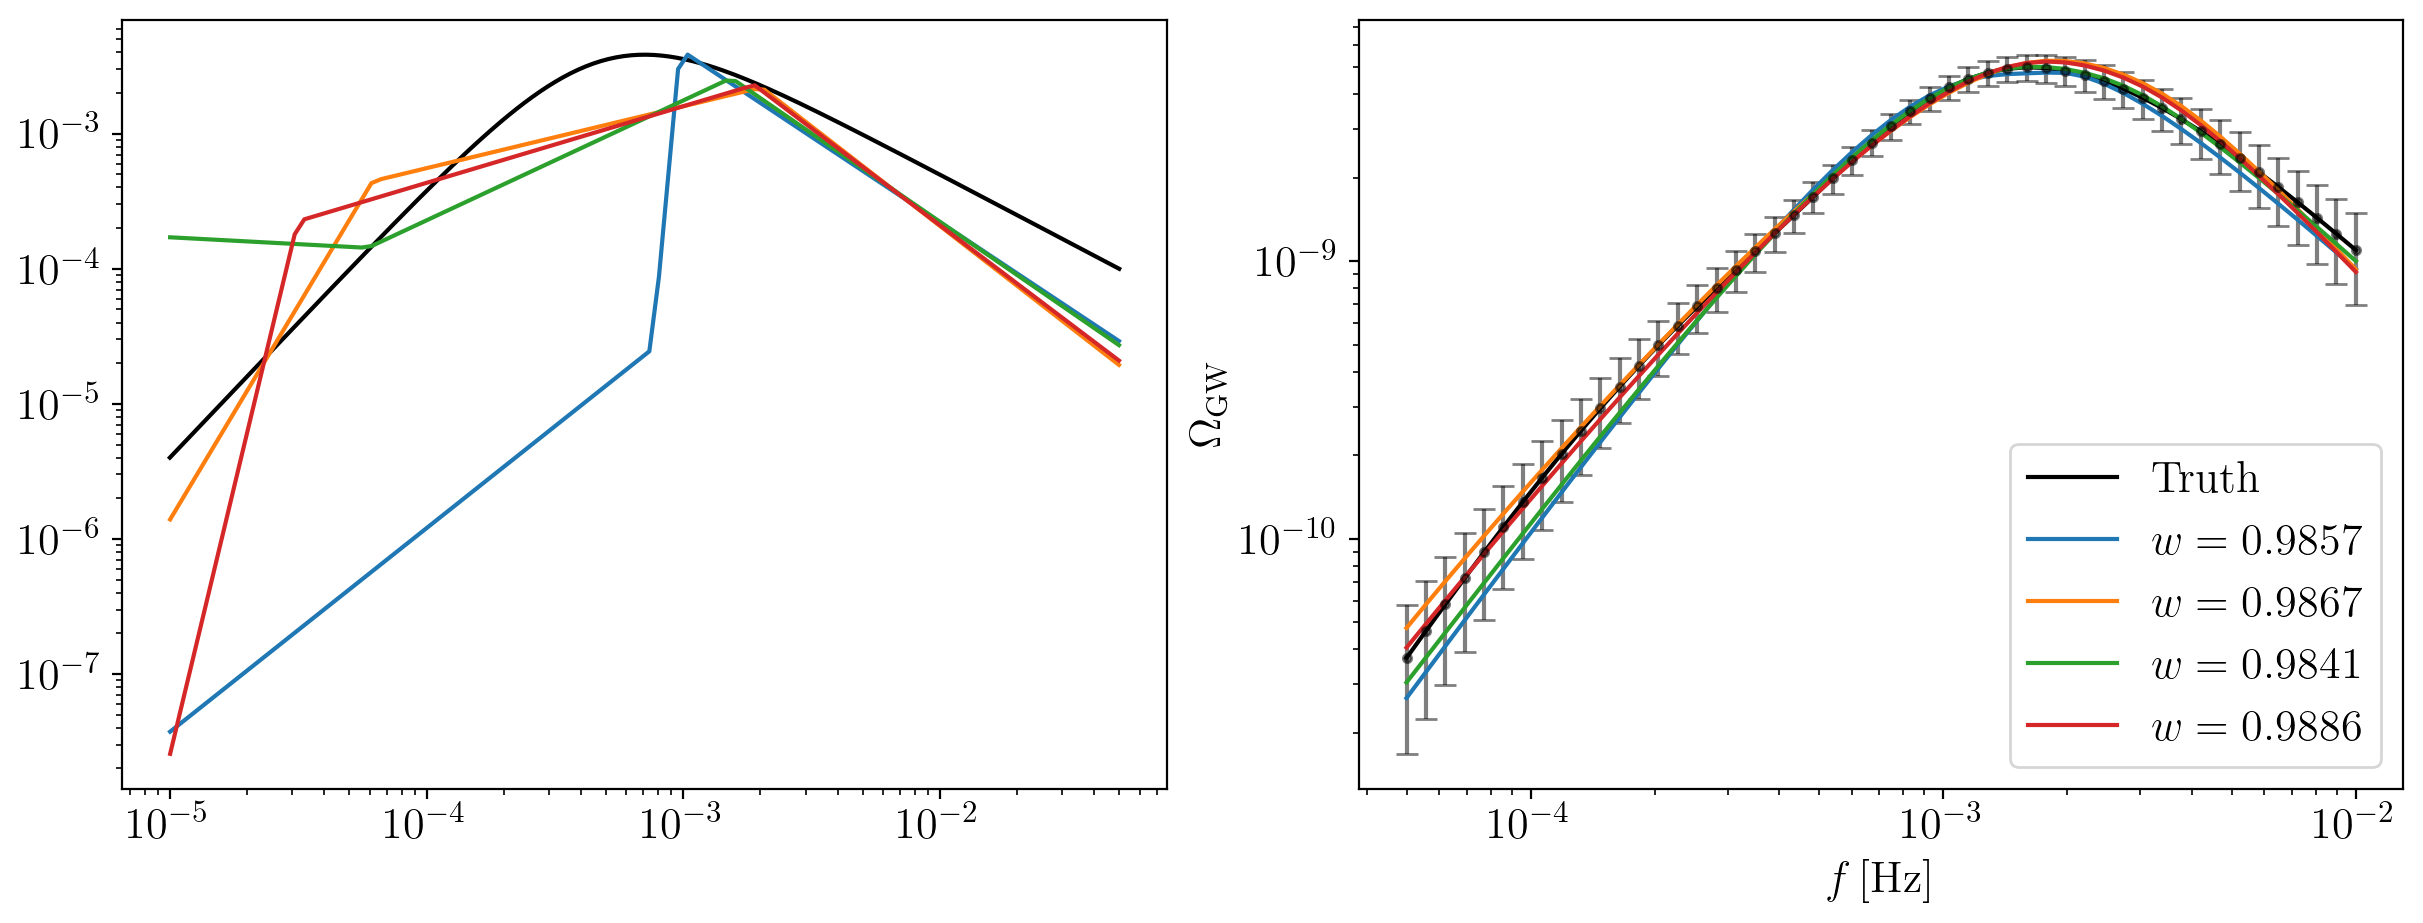

In [15]:
# plot some samples with w>0.98

samps_cut = samples[samples[:,0] > 0.98]
logl_cut = logl[samples[:,0] > 0.98]
weights_cut = weights[samples[:,0] > 0.98]

print(f"Shapes: {samps_cut.shape}, {logl_cut.shape}, {weights_cut.shape}")

print(f"Cut samples max logl: {max(logl_cut)}, min logl: {min(logl_cut)}")
print(f"Full samples max logl: {max(logl)}, min logl: {min(logl)}")

# get samples with w>0.95 and logl > -10
cut = logl_cut > -10
samps_cut = samps_cut[cut]
logl_cut = logl_cut[cut]
weights_cut = weights_cut[cut]
print(f"Shapes: {samps_cut.shape}, {logl_cut.shape}, {weights_cut.shape}")


fig, ax = plt.subplots(1,2,figsize=(12,4.5),constrained_layout=True)

ax[0].loglog(pk_arr,pz_amp, color='k', lw=1.5)

ax[1].loglog(frequencies, Omegas, color='k', lw=1.5, label='Truth')
ax[1].errorbar(frequencies, Omegas, yerr=np.sqrt(np.diag(cov)), fmt='o', color='k', capsize=4.,alpha=0.5,markersize=3)
for s in samps_cut[::50]:
    w = s[0]
    free_nodes = s[1:num_nodes-1]
    nodes = np.pad(free_nodes, (1,1), 'constant', constant_values=(left_node, right_node))
    vals = s[num_nodes-1:]
    pz = compute_pz(p_arr, np.atleast_2d(s))
    ax[0].loglog(p_arr, pz[0], label=f'$w={w:.2f}$')
    OmegaGW = compute_w(w,-5., nodes, vals, frequencies)
    # rescale = max(Omegas)/max(OmegaGW)
    # OmegaGW *= rescale
    ax[1].loglog(frequencies, OmegaGW, label=f'$w={w:.4f}$')
ax[1].legend()
ax[1].set_xlabel(r'$f\,{\rm [Hz]}$')
ax[1].set_ylabel(r'$\Omega_{\rm GW}$')

Shapes: (11069, 7), (11069,), (11069,)
Cut samples max logl: -7.339505705907914, min logl: -139761938217470.72
Full samples max logl: -6.646672322509872, min logl: -158616827931060.6
Shapes: (282, 7), (282,), (282,)


Pz: 100%|██████████| 1/1 [00:00<00:00, 16070.13it/s]


Text(0, 0.5, '$\\Omega_{\\rm GW}$')

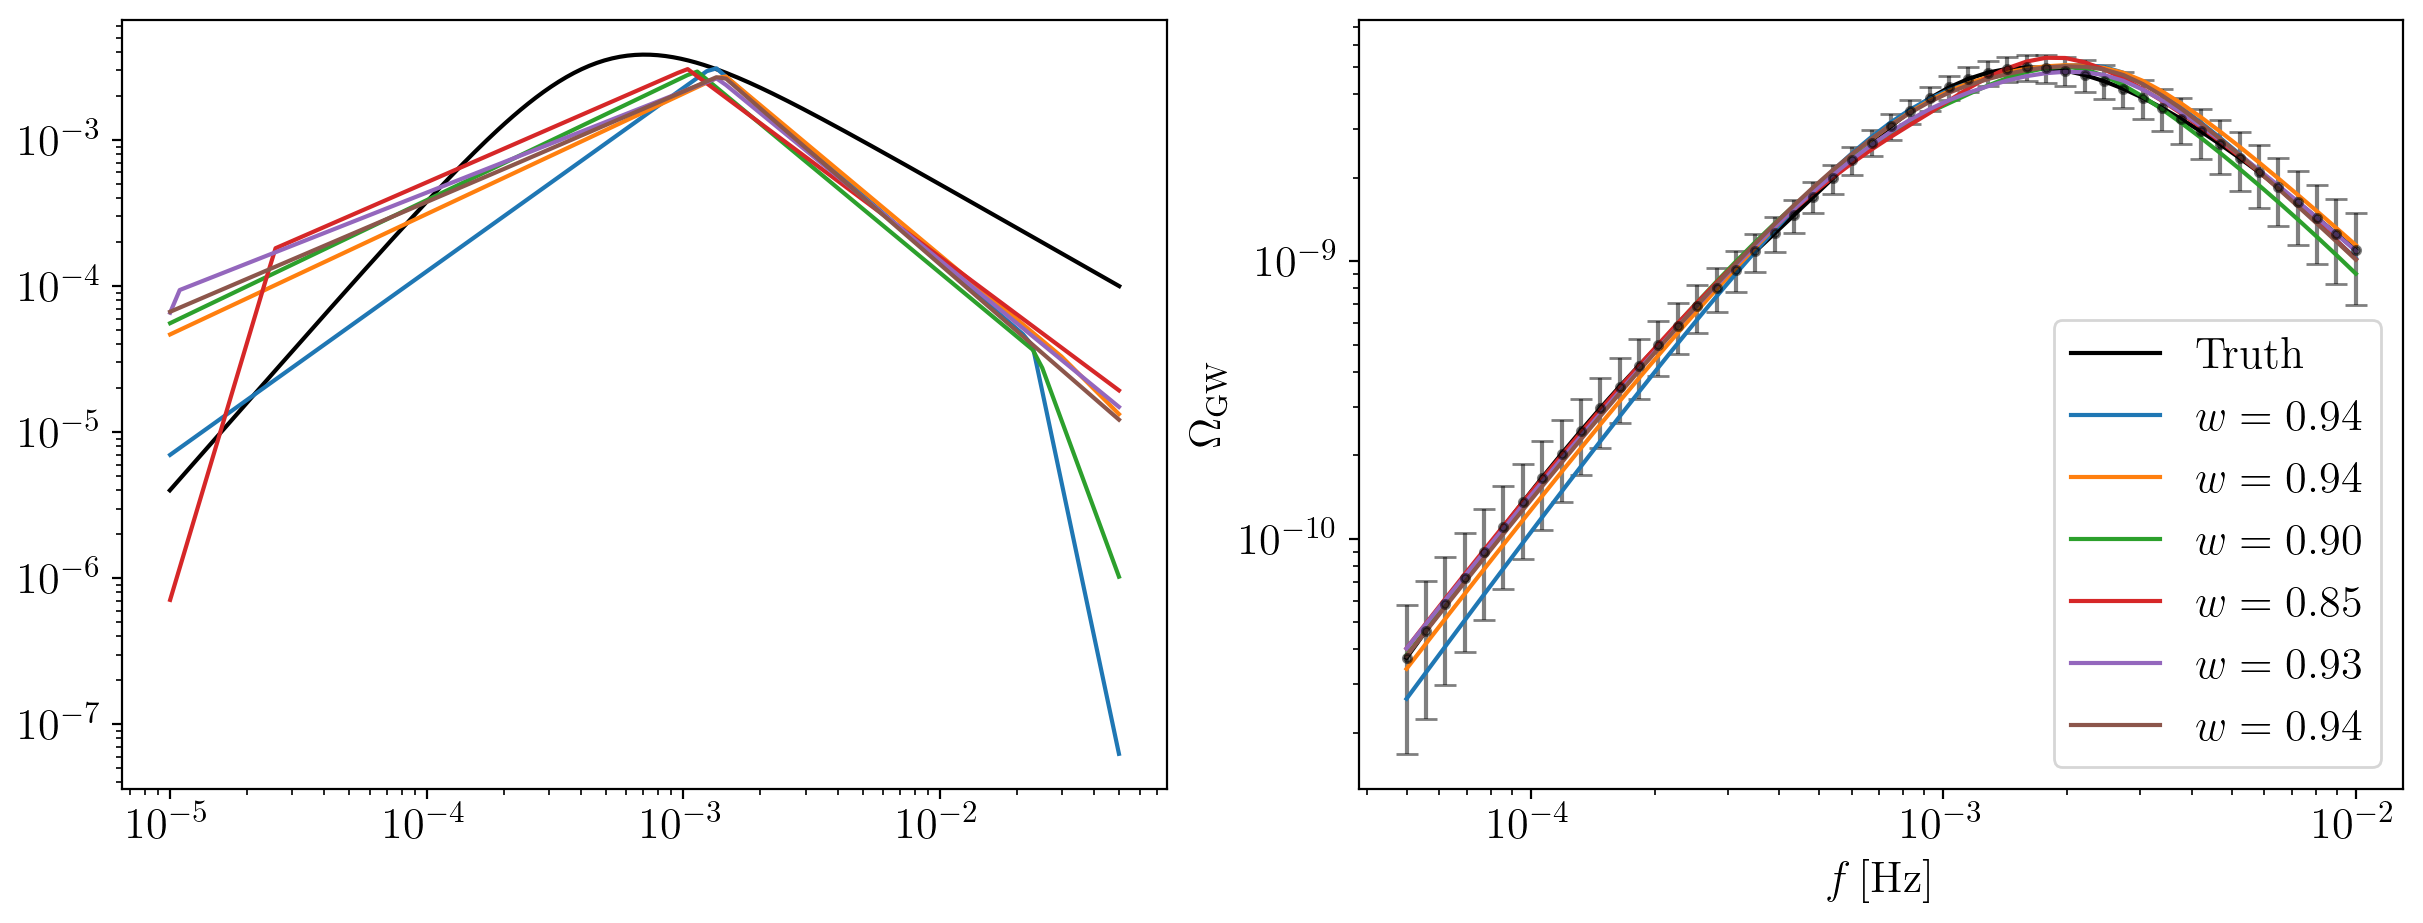

In [17]:
# plot some samples with 0.8<w<0.9

cut = (samples[:,0] < 0.95) & (samples[:,0] > 0.85)
samps_cut = samples[cut]
logl_cut = logl[cut]
weights_cut = weights[cut]

print(f"Shapes: {samps_cut.shape}, {logl_cut.shape}, {weights_cut.shape}")

print(f"Cut samples max logl: {max(logl_cut)}, min logl: {min(logl_cut)}")
print(f"Full samples max logl: {max(logl)}, min logl: {min(logl)}")

# get samples with w>0.95 and logl > -10
cut = logl_cut > -10
samps_cut = samps_cut[cut]
logl_cut = logl_cut[cut]
weights_cut = weights_cut[cut]
print(f"Shapes: {samps_cut.shape}, {logl_cut.shape}, {weights_cut.shape}")


fig, ax = plt.subplots(1,2,figsize=(12,4.5),constrained_layout=True)

ax[0].loglog(pk_arr,pz_amp, color='k', lw=1.5)

ax[1].loglog(frequencies, Omegas, color='k', lw=1.5, label='Truth')
ax[1].errorbar(frequencies, Omegas, yerr=np.sqrt(np.diag(cov)), fmt='o', color='k', capsize=4.,alpha=0.5,markersize=3)
for s in samps_cut[::50]:
    w = s[0]
    free_nodes = s[1:num_nodes-1]
    nodes = np.pad(free_nodes, (1,1), 'constant', constant_values=(left_node, right_node))
    vals = s[num_nodes-1:]
    pz = compute_pz(p_arr, np.atleast_2d(s))
    ax[0].loglog(p_arr, pz[0], label=f'$w={w:.2f}$')
    OmegaGW = compute_w(w,-5., nodes, vals, frequencies)
    # rescale = max(Omegas)/max(OmegaGW)
    # OmegaGW *= rescale
    ax[1].loglog(frequencies, OmegaGW, label=f'$w={w:.2f}$')
ax[1].legend()
ax[1].set_xlabel(r'$f\,{\rm [Hz]}$')
ax[1].set_ylabel(r'$\Omega_{\rm GW}$')